# 🎯 Long-Text Uncertainty Quantification

<div style="background-color: rgba(200, 200, 200, 0.1); padding: 20px; border-radius: 8px; margin-bottom: 20px; border: 1px solid rgba(127, 127, 127, 0.2); max-width: 97.5%; overflow-wrap: break-word;">
  <p style="font-size: 16px; line-height: 1.6">
    Long-Text Uncertainty Quantification (LUQ) is a long-form adaptation of black-box uncertainty quantification. This approach generates multiple responses to the same prompt, decomposes those responses into granular units (sentences or claims), and scores those units by measuring whether sampled responses entail each unit. This demo provides an illustration 
    of how to use the LUQ methods with <code>uqlm</code>. The available scorers and papers from which they are adapted are below:
  </p>
      
*   Long-text Uncertainty Quantification (LUQ) ([Zhang et al., 2024](https://arxiv.org/abs/2403.20279))
*   LUQ-Atomic ([Zhang et al., 2024](https://arxiv.org/abs/2403.20279))
*   LUQ-pair ([Zhang et al., 2024](https://arxiv.org/abs/2403.20279))
*   Generalized LUQ-pair ([Zhang et al., 2024](https://arxiv.org/abs/2403.20279))

</div>

## 📊 What You'll Do in This Demo

<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>1</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section1>Set up LLM and prompts.</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Set up LLM instance and load example data prompts.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>2</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section2>Generate LLM Responses and Confidence Scores</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Generate responses and compute claim-level confidence scores using the <code>LongTextUQ()</code> class.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 25px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>3</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section3>Evaluate Hallucination Detection Performance</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Grade claims with `FactScoreGrader` class and evaluate claim-level hallucination detection.</p>
  </div>
</div>

## ⚖️ Advantages & Limitations

<div style="display: flex; gap: 20px">
  <div style="flex: 1; background-color: rgba(0, 200, 0, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(0, 200, 0, 0.2)">
    <h3 style="color: #2e8b57; margin-top: 0">Pros</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Universal Compatibility:</strong> Works with any LLM without requiring token probability access</li>
      <li><strong>Fine-Grained Scoring:</strong> Score at sentence or claim-level to localize likely hallucinations</li>
      <li><strong>Uncertainty-aware decoding:</strong> Improve factual precision by dropping high-uncertainty claims</li>
    </ul>
  </div>
  
  <div style="flex: 1; background-color: rgba(200, 0, 0, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(200, 0, 0, 0.2)">
    <h3 style="color: #b22222; margin-top: 0">Cons</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Higher Cost:</strong> Requires multiple generations per prompt</li>
      <li><strong>Slower:</strong> Multiple generations and comparison calculations increase latency</li>
    </ul>
  </div>
</div>

In [1]:
import numpy as np

from uqlm import LongTextUQ
from uqlm.utils import load_example_dataset, display_response_refinement, claims_dicts_to_lists, plot_model_accuracies
from uqlm.longform import FactScoreGrader

## 1. Set up LLM and Prompts

In this demo, we will illustrate this approach using the [FactScore](https://github.com/shmsw25/FActScore/tree/main/factscore) longform QA dataset. To implement with your use case, simply **replace the example prompts with your data**.  

In [2]:
# Load example dataset (FactScore)
factscore = load_example_dataset("factscore", n=20)[["factscore_prompt", "wikipedia_text"]].rename(columns={"factscore_prompt": "prompt"})
factscore.head()

Loading dataset - factscore...
Processing dataset...
Dataset ready!


,prompt,wikipedia_text
0,Tell me a bio of Suthida.\n,Suthida Bajrasudhabimalalakshana (Thai: สมเด็จ...
1,Tell me a bio of Miguel Ángel Félix Gallardo.\n,"Miguel Ángel Félix Gallardo (born January 8, 1..."
2,Tell me a bio of Iggy Azalea.\n,"Amethyst Amelia Kelly (born 7 June 1990), know..."
3,Tell me a bio of Fernando da Costa Novaes.\n,"Fernando da Costa Novaes (April 6, 1927 – Marc..."
4,Tell me a bio of Jan Zamoyski.\n,Jan Sariusz Zamoyski (Latin: Ioannes Zamoyski ...


In this example, we use `AzureChatOpenAI` to instantiate our LLM, but any [LangChain Chat Model](https://js.langchain.com/docs/integrations/chat/) may be used. Be sure to **replace with your LLM of choice.**

In [3]:
# import sys
# !{sys.executable} -m pip install langchain-openai

## User to populate .env file with API credentials
from dotenv import load_dotenv, find_dotenv
from langchain_openai import AzureChatOpenAI

load_dotenv(find_dotenv())
llm = AzureChatOpenAI(
    deployment_name="gpt-4o",
    openai_api_type="azure",
    openai_api_version="2024-12-01-preview",
    temperature=1,  # User to set temperature
)

## 2. Generate LLM Responses and Claim/Sentence-Level Confidence Scores

### `LongTextUQ()` - Generate long-text LLM responses, decompose into claims or sentences, and measure entailment among sampled responses.

![Sample Image](https://raw.githubusercontent.com/cvs-health/uqlm/develop/assets/images/luq_example.png)

#### 📋 Class Attributes

<table style="border-collapse: collapse; width: 100%; border: 1px solid rgba(127, 127, 127, 0.2);">
  <tr>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 20%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Parameter</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 25%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Type & Default</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 55%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Description</th>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">llm</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">BaseChatModel<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">A langchain llm `BaseChatModel`. User is responsible for specifying temperature and other relevant parameters to the constructor of the provided `llm` object.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">granularity</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str<br><code>default="claim"</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies whether to decompose and score at claim or sentence level granularity. Must be either "claim" or "sentence".</td>
  </tr>  
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">mode</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str<br><code>default="unit_response"</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies whether to implement unit-response (LUQ-style) scoring or matched-unit (LUQ-pair-style) scoring. Must be either "unit_response" (recommended) or "matched_unit".</td>
  </tr>  
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">scorers</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">List[str]<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies which black box (consistency) scorers to include. subset of {"entailment", "noncontradiction", "contrasted_entailment", "bert_score", "cosine_sim"}. If None, defaults to ["entailment"].</td>
  </tr>    
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">aggregation</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str<br><code>default="mean"</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies how to aggregate claim/sentence-level scores to response-level scores. Must be one of 'min' or 'mean'.</td>
  </tr>  
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">response_refinement</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">bool<br><code>default=False</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies whether to refine responses with uncertainty-aware decoding. This approach removes claims with confidence scores below the response_refinement_threshold and uses the claim_decomposition_llm to reconstruct the response from the retained claims. For more details, refer to Jiang et al., 2024: https://arxiv.org/abs/2410.20783</td>
  </tr>  
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">claim_filtering_scorer</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Optional[str]<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies which scorer to use to filter claims if response_refinement is True. If not provided, defaults to the first element of self.scorers.</td>
  </tr>   
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">claim_decomposition_llm</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">BaseChatModel<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">A langchain llm `BaseChatModel` to be used for decomposing responses into individual claims. Also used for claim refinement. If granularity="claim" and claim_decomposition_llm is None, the provided `llm` will be used for claim decomposition.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">nli_llm</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">BaseChatModel<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">A LangChain chat model for LLM-based NLI inference. If provided, takes precedence over nli_model_name. Only used for mode="unit_response"</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">device</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str or torch.device<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies the device that NLI model use for prediction. If None, detects and returns the best available PyTorch device. Prioritizes CUDA (NVIDIA GPU), then MPS (macOS), then CPU.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">system_prompt</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str or None<br><code>default="You are a helpful assistant."</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Optional argument for user to provide custom system prompt for the LLM.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">max_calls_per_min</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">int<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies how many API calls to make per minute to avoid rate limit errors. By default, no limit is specified.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">use_n_param</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">bool<br><code>default=False</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies whether to use <code>n</code> parameter for <code>BaseChatModel</code>. Not compatible with all <code>BaseChatModel</code> classes. If used, it speeds up the generation process substantially when <code>num_responses</code> is large.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">sampling_temperature</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">float<br><code>default=1</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">The 'temperature' parameter for LLM to use when generating sampled LLM responses. Must be greater than 0.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">nli_model_name</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str<br><code>default="microsoft/deberta-large-mnli"</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies which NLI model to use. Must be acceptable input to <code>AutoTokenizer.from_pretrained()</code> and <code>AutoModelForSequenceClassification.from_pretrained()</code>.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">max_length</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">int<br><code>default=2000</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies the maximum allowed string length for LLM responses for NLI computation. Responses longer than this value will be truncated in NLI computations to avoid <code>OutOfMemoryError</code>.</td>
  </tr>
</table>

#### 🔍 Parameter Groups

<div style="display: flex; gap: 20px; margin-bottom: 20px">
  <div style="flex: 1; padding: 10px; background-color: rgba(0, 100, 200, 0.1); border-radius: 5px; border: 1px solid rgba(0, 100, 200, 0.2);">
    <p style="font-weight: bold">🧠 LLM-Specific</p>
    <ul>
      <li><code>llm</code></li>
      <li><code>system_prompt</code></li>
      <li><code>sampling_temperature</code></li>
      <li><code>claim_decomposition_llm</code></li>
      <li><code>nli_llm</code></li>
    </ul>
  </div>
  <div style="flex: 1; padding: 10px; background-color: rgba(0, 200, 0, 0.1); border-radius: 5px; border: 1px solid rgba(0, 200, 0, 0.2);">
    <p style="font-weight: bold">📊 Confidence Scores</p>
    <ul>
      <li><code>granularity</code></li>
      <li><code>scorers</code></li>
      <li><code>mode</code></li>
      <li><code>aggregation</code></li>
      <li><code>response_refinement</code></li>        
      <li><code>response_refinement_threshold</code></li>  
    </ul>
  </div>
  <div style="flex: 1; padding: 10px; background-color: rgba(200, 150, 0, 0.1); border-radius: 5px; border: 1px solid rgba(200, 150, 0, 0.2);">
    <p style="font-weight: bold">🖥️ Hardware</p>
    <ul>
      <li><code>device</code></li>
    </ul>
  </div>
  <div style="flex: 1; padding: 10px; background-color: rgba(200, 0, 200, 0.1); border-radius: 5px; border: 1px solid rgba(200, 0, 200, 0.2);">
    <p style="font-weight: bold">⚡ Performance</p>
    <ul>
      <li><code>max_calls_per_min</code></li>
      <li><code>use_n_param</code></li>
    </ul>
  </div>
</div>

```

In [4]:
luq = LongTextUQ(
    llm=llm,
    granularity="claim",  # 'claim' recommended
    aggregation="mean",  # switch to 'min' for more conservative scoring
    response_refinement=True,  # whether to filter out low-confidence claims
    max_calls_per_min=80,
    max_length=3000,
)

claim_filtering_scorer is not specified for response_refinement. Defaulting to entailment.


### 🔄 Class Methods

<table style="border-collapse: collapse; width: 100%; border: 1px solid rgba(127, 127, 127, 0.2);">
  <tr>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 25%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Method</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 75%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Description & Parameters</th>
  </tr>
  <tr>
    <td style="font-weight: bold; vertical-align: top; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">BlackBoxUQ.generate_and_score</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">
      <p>Generate LLM responses, sampled LLM (candidate) responses, and compute confidence scores for the provided prompts.</p>
      <p><strong>Parameters:</strong></p>
      <ul>
        <li><code>prompts</code> - (<strong>List[str] or List[List[BaseMessage]]</strong>) A list of input prompts for the model.</li>
        <li><code>num_responses</code> - (<strong>int, default=5</strong>) The number of sampled responses used to compute consistency.</li>
        <li><code>response_refinement_threshold</code> - (<strong>float, default=1/3</strong>) Threshold for uncertainty-aware filtering. Claims with confidence scores below this threshold are dropped from the refined response. Only used if response_refinement is True.</li>        
        <li><code>show_progress_bars</code> - (<strong>bool, default=True</strong>) If True, displays a progress bar while generating and scoring responses.</li>        
      </ul>
      <p><strong>Returns:</strong> <code>UQResult</code> containing data (prompts, responses, sampled responses, and confidence scores) and metadata</p>
      <div style="background-color: rgba(0, 200, 0, 0.1); padding: 8px; border-radius: 3px; margin-top: 10px; border: 1px solid rgba(0, 200, 0, 0.2); margin-right: 5px; box-sizing: border-box; width: 100%;">
        <strong>💡 Best For:</strong> Complete end-to-end uncertainty quantification when starting with prompts.
      </div>
    </td>
  </tr>
  <tr>
    <td style="font-weight: bold; vertical-align: top; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">BlackBoxUQ.score</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">
      <p>Compute confidence scores on provided LLM responses. Should only be used if responses and sampled responses are already generated.</p>
      <p><strong>Parameters:</strong></p>
      <ul>
        <li><code>responses</code> - (<strong>List[str]</strong>) A list of LLM responses for the prompts.</li>
        <li><code>sampled_responses</code> - (<strong>List[List[str]]</strong>) A list of lists of sampled LLM responses for each prompt. Used to compute consistency scores by comparing to the corresponding response from <code>responses</code>.</li>
        <li><code>response_refinement_threshold</code> - (<strong>float, default=1/3</strong>) Threshold for uncertainty-aware filtering. Claims with confidence scores below this threshold are dropped from the refined response. Only used if response_refinement is True.</li>        
        <li><code>show_progress_bars</code> - (<strong>bool, default=True</strong>) If True, displays a progress bar while scoring responses.</li>  
      </ul>
      <p><strong>Returns:</strong> <code>UQResult</code> containing data (responses, sampled responses, and confidence scores) and metadata</p>
      <div style="background-color: rgba(0, 200, 0, 0.1); padding: 8px; border-radius: 3px; margin-top: 10px; border: 1px solid rgba(0, 200, 0, 0.2); margin-right: 5px; box-sizing: border-box; width: 100%;">
        <strong>💡 Best For:</strong> Computing uncertainty scores when responses are already generated elsewhere.
      </div>
    </td>
  </tr>
</table>

In [5]:
results = await luq.generate_and_score(
    prompts=factscore.prompt.to_list(),
    num_responses=5,  # choose num_responses based on cost and latency requirements (higher means better hallucination detection but more cost and latency)
)

Output()

In [6]:
result_df = results.to_df()
result_df.head(5)

,prompt,response,sampled_responses,entailment,claims_data,refined_response,refined_entailment
0,Tell me a bio of Suthida.\n,"Suthida Bajrasudhabimalalakshana, born on June...","[Suthida Bajrasudhabimalalakshana, commonly kn...",0.378289,[{'claim': 'Suthida Bajrasudhabimalalakshana w...,"Suthida Bajrasudhabimalalakshana, born on June...",0.786631
1,Tell me a bio of Miguel Ángel Félix Gallardo.\n,"Miguel Ángel Félix Gallardo, often referred to...","[Miguel Ángel Félix Gallardo, often referred t...",0.472164,[{'claim': 'Miguel Ángel Félix Gallardo is oft...,"Miguel Ángel Félix Gallardo, often referred to...",0.654868
2,Tell me a bio of Iggy Azalea.\n,"Iggy Azalea, born Amethyst Amelia Kelly on Jun...","[Iggy Azalea, born Amethyst Amelia Kelly on Ju...",0.468483,[{'claim': 'Iggy Azalea was born Amethyst Amel...,"Iggy Azalea, born Amethyst Amelia Kelly on Jun...",0.650532
3,Tell me a bio of Fernando da Costa Novaes.\n,Fernando da Costa Novaes was a prominent Brazi...,[Fernando da Costa Novaes was a Brazilian orni...,0.494438,[{'claim': 'Fernando da Costa Novaes was a pro...,Fernando da Costa Novaes was a highly respecte...,0.705326
4,Tell me a bio of Jan Zamoyski.\n,Jan Zamoyski (1542–1605) was a prominent Polis...,[Jan Zamoyski (1542–1605) was a prominent Poli...,0.573752,[{'claim': 'Jan Zamoyski was a Polish nobleman...,"Jan Zamoyski, born in 1542 and deceased in 160...",0.733766


#### Response refinement

Response refinement works by dropping claims with confidence scores (specified with `claim_filtering_scorer`) below a specified threshold (specified with `response_refinement_threshold`) and reconstructing the response from the retained claims.

![Sample Image](https://raw.githubusercontent.com/cvs-health/uqlm/develop/assets/images/uad_graphic.png)

To illustrate how the response refinement operates, let's view an example. We first view the fine-grained claim-level data, including the claims in the original response, the claim-level confidence scores, and whether each claim was removed during the response refinement process. 

In [7]:
# View fine-grained claim data for the first response
result_df.claims_data[0]

[{'claim': 'Suthida Bajrasudhabimalalakshana was born on June 3, 1978.',
  'removed': False,
  'entailment': 0.9548099517822266},
 {'claim': 'Suthida Bajrasudhabimalalakshana is the Queen of Thailand.',
  'removed': False,
  'entailment': 0.909833800792694},
 {'claim': 'Suthida Bajrasudhabimalalakshana became queen following her marriage to King Maha Vajiralongkorn on May 1, 2019.',
  'removed': False,
  'entailment': 0.9487567067146301},
 {'claim': 'Suthida Bajrasudhabimalalakshana was known for her service in the Thai military.',
  'removed': False,
  'entailment': 0.6286507695913315},
 {'claim': 'Suthida Bajrasudhabimalalakshana was known for her service in royal security.',
  'removed': False,
  'entailment': 0.4196613132953644},
 {'claim': 'Suthida Bajrasudhabimalalakshana joined the Thai military.',
  'removed': False,
  'entailment': 0.8370264410972595},
 {'claim': 'Suthida Bajrasudhabimalalakshana rose to the rank of General in the Thai military.',
  'removed': False,
  'entail

We can then visualize the response refinement process for this response using the `display_response_refinement`. This shows the original response vs. the refined response and identifies which claims were removed due to low confidence.

In [8]:
display_response_refinement(original_text=result_df.response[0], claims_data=result_df.claims_data[0], refined_text=result_df.refined_response[0])

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Response Refinement Example

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

╭─────────────────────────────────────────────── Original Response ───────────────────────────────────────────────╮
│ Suthida Bajrasudhabimalalakshana, born on June 3, 1978, is the Queen of Thailand. She became queen following    │
│ her marriage to King Maha Vajiralongkorn (Rama X) on May 1, 2019.                                               │
│                                                                                                                 │
│ Before becoming queen, Suthida was known for her service in the Thai military and royal security. She joined    │
│ the Thai military, where she eventually rose to the rank of General. Her notable role was as the Deputy         │
│ Commander of the King’s Own Bodyguard Battalion. Suthida was also appointed as the Commander of the Special     │
│ Operations Unit of the King’s Guard in 2013, and later, she was made the Commander of the Royal Thai            │
│ Aide-de-Camp Department.                                                                                        │
│                                                                                                                 │
│ Her service to the royal family and her close association with King Vajiralongkorn began during his time as     │
│ Crown Prince. Suthida was appointed as a General in the Royal Thai Army in December 2016, shortly after         │
│ Vajiralongkorn ascended to the throne.                                                                          │
│                                                                                                                 │
│ Queen Suthida's royal name, bestowed upon her after marriage, is Her Majesty Queen Suthida                      │
│ Bajrasudhabimalalakshana. The marriage and her subsequent coronation as queen were part of the elaborate royal  │
│ ceremonies that solidified her position as the consort of the reigning monarch.                                 │
│                                                                                                                 │
│ Queen Suthida is known for her dignity and dedication to her roles both in royal duties and her previous        │
│ military service. Her work and public engagements often highlight charitable activities and support for various │
│ social causes within Thailand.                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────── Low-Confidence Claims to be Removed ──────────────────────────────────────╮
│ • Suthida Bajrasudhabimalalakshana's notable role was as the Deputy Commander of the King’s Own Bodyguard       │
│ Battalion.                                                                                                      │
│ • Suthida Bajrasudhabimalalakshana was appointed as the Commander of the Special Operations Unit of the King’s  │
│ Guard in 2013.                                                                                                  │
│ • Suthida Bajrasudhabimalalakshana was made the Commander of the Royal Thai Aide-de-Camp Department.            │
│ • Suthida Bajrasudhabimalalakshana's service to the royal family began during Vajiralongkorn's time as Crown    │
│ Prince.                                                                                                         │
│ • Suthida Bajrasudhabimalalakshana was appointed as a General in the Royal Thai Army in December 2016.          │
│ • Vajiralongkorn ascended to the throne shortly before December 2016.                                           │
│ • The marriage and Queen Suthida's subsequent coronation were part of the elaborate royal ceremonies.           │
│ • The elaborate royal ceremonies solidified Queen Suthida's position as the consort of the reigning monarch.    │
│ • Queen Suthida is known for her dignity.                                                                       │
│ • Queen Suthida is known for her dedication to her roles in royal duties.                                       │
│ • Queen Suthida is known for her dedication to her previous military service.                                   │
│ • Queen Suthida's work and public engagements often highlight charitable activities in Thailand.                │
│ • Queen Suthida's work and public engagements often support various social causes within Thailand.              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── Refined Response ────────────────────────────────────────────────╮
│ Suthida Bajrasudhabimalalakshana, born on June 3, 1978, is the Queen of Thailand. She became queen following    │
│ her marriage to King Maha Vajiralongkorn on May 1, 2019, and upon marriage, she was bestowed with the royal     │
│ name Her Majesty Queen Suthida Bajrasudhabimalalakshana. Before her ascension to the throne, Queen Suthida was  │
│ recognized for her dedicated service in the Thai military, where she rose to the rank of General, and in royal  │
│ security. Her military career and commitment to royal security played a significant role in her rise to         │
│ prominence, ultimately leading to her role as queen.                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## 3. Evaluate Hallucination Detection Performance

To evaluate hallucination detection performance, we 'grade' the atomic claims in the responses against an answer key. Here, we use UQLM's out-of-the-box `FactScoreGrader`, which can be used with [LangChain Chat Model](https://js.langchain.com/docs/integrations/chat/). **If you are using your own prompts/questions, be sure to update the grading method accordingly**.

In [9]:
# set up the LLM grader
from langchain_google_vertexai import ChatVertexAI

gemini_flash = ChatVertexAI(model="gemini-2.5-flash")
grader = FactScoreGrader(llm=gemini_flash)

Before grading, we need to have claims formatted in list of lists where each interior list corresponds to a generated response. 

In [10]:
# Convert claims to list of lists
claims_data_lists = claims_dicts_to_lists(result_df.claims_data.tolist())

In [12]:
# grade original responses against the answer key using the grader
result_df["claim_grades"] = await grader.grade_claims(claim_sets=claims_data_lists["claim"], answers=factscore["wikipedia_text"].to_list())
result_df["answer"] = factscore["wikipedia_text"]
result_df.head(5)

,prompt,response,sampled_responses,entailment,claims_data,refined_response,refined_entailment,claim_grades,answer
0,Tell me a bio of Suthida.\n,"Suthida Bajrasudhabimalalakshana, born on June...","[Suthida Bajrasudhabimalalakshana, commonly kn...",0.378289,[{'claim': 'Suthida Bajrasudhabimalalakshana w...,"Suthida Bajrasudhabimalalakshana, born on June...",0.786631,"[True, True, False, True, True, True, True, Fa...",Suthida Bajrasudhabimalalakshana (Thai: สมเด็จ...
1,Tell me a bio of Miguel Ángel Félix Gallardo.\n,"Miguel Ángel Félix Gallardo, often referred to...","[Miguel Ángel Félix Gallardo, often referred t...",0.472164,[{'claim': 'Miguel Ángel Félix Gallardo is oft...,"Miguel Ángel Félix Gallardo, often referred to...",0.654868,"[True, True, True, True, False, True, True, Tr...","Miguel Ángel Félix Gallardo (born January 8, 1..."
2,Tell me a bio of Iggy Azalea.\n,"Iggy Azalea, born Amethyst Amelia Kelly on Jun...","[Iggy Azalea, born Amethyst Amelia Kelly on Ju...",0.468483,[{'claim': 'Iggy Azalea was born Amethyst Amel...,"Iggy Azalea, born Amethyst Amelia Kelly on Jun...",0.650532,"[True, True, True, True, False, True, True, Fa...","Amethyst Amelia Kelly (born 7 June 1990), know..."
3,Tell me a bio of Fernando da Costa Novaes.\n,Fernando da Costa Novaes was a prominent Brazi...,[Fernando da Costa Novaes was a Brazilian orni...,0.494438,[{'claim': 'Fernando da Costa Novaes was a pro...,Fernando da Costa Novaes was a highly respecte...,0.705326,"[True, True, True, True, False, True, True, Tr...","Fernando da Costa Novaes (April 6, 1927 – Marc..."
4,Tell me a bio of Jan Zamoyski.\n,Jan Zamoyski (1542–1605) was a prominent Polis...,[Jan Zamoyski (1542–1605) was a prominent Poli...,0.573752,[{'claim': 'Jan Zamoyski was a Polish nobleman...,"Jan Zamoyski, born in 1542 and deceased in 160...",0.733766,"[True, True, True, True, True, True, True, Tru...",Jan Sariusz Zamoyski (Latin: Ioannes Zamoyski ...


In [13]:
all_claim_scores, all_claim_grades = [], []
for i in range(len(result_df)):
    all_claim_scores.extend(claims_data_lists["entailment"][i])
    all_claim_grades.extend(result_df["claim_grades"][i])

print(f"""Baseline LLM accuracy: {np.mean(all_claim_grades)}""")

Baseline LLM accuracy: 0.6737967914438503


#### 3.1 Claim-Level Hallucination Detection AUROC

To evaluate fine-grained hallucination detection performance, we compute AUROC of claim-level hallucination detection. Below, we plot the ROC curve and report these results.

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_true=all_claim_grades, y_score=all_claim_scores)
roc_auc = roc_auc_score(y_true=all_claim_grades, y_score=all_claim_scores)

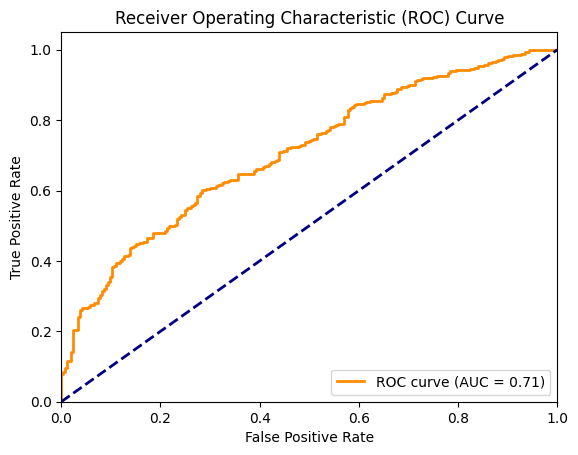

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

#### 3.2 Gains from Uncertainty-Aware Decoding

Lastly, we evaluate the gains from uncertainty-aware decoding (UAD) by measuring the factual precision over claims at various filtering thresholds. 

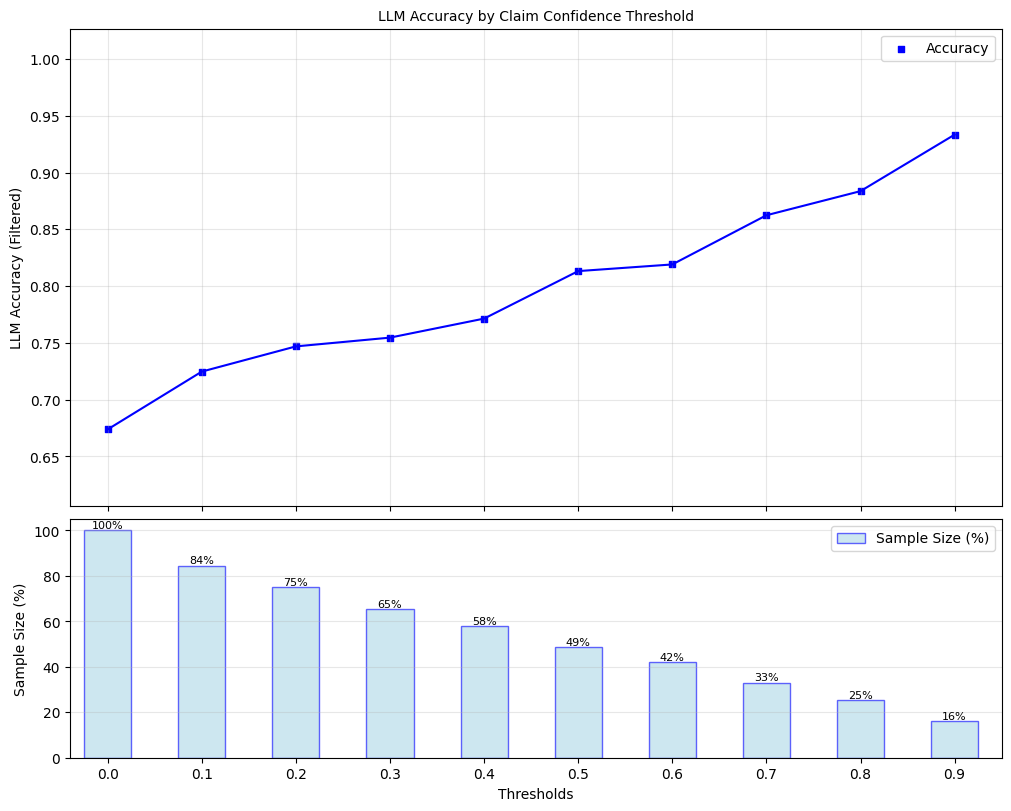

In [16]:
plot_model_accuracies(scores=all_claim_scores, correct_indicators=all_claim_grades, title="LLM Accuracy by Claim Confidence Threshold", display_percentage=True)

Since, we have selected a threshold of 1/3, we can measure LLM accuracy with and without UAD.

In [17]:
thresh = 1 / 3
filtered_grades, filtered_scores = [], []
for grade, score in zip(all_claim_grades, all_claim_scores):
    if score > thresh:
        filtered_grades.append(grade)
        filtered_scores.append(score)

print(f"Baseline LLM factual precision: {np.mean(all_claim_grades)}")
print(f"UAD-Improved LLM factual precision: {np.mean(filtered_grades)}")

Baseline LLM factual precision: 0.6737967914438503
UAD-Improved LLM factual precision: 0.7665952890792291


## 4. Scorer Definitions

Long-form uncertainty quantification implements a three-stage pipeline after response generation:

1. Response Decomposition: The response $y$ is decomposed into units (claims or sentences), where a unit as denoted as $s$.

2. Unit-Level Confidence Scoring: Confidence scores are computed using function $c_g(s;\cdot) \in [0, 1]$. Higher scores indicate greater likelihood of factual correctness. Units with scores below threshold $\tau$ are flagged as potential hallucinations.

3. Response-Level Aggregation: Unit scores are combined to provide an overall response confidence.

The Long-text UQ (LUQ) approach demonstrated here is adapted from [Zhang et al., 2024](https://arxiv.org/abs/2403.20279). Similar to standard black-box UQ, this approach requires generating a original response and sampled candidate responses to the same prompt. The original response is then decomposed into units (claims or sentences). Unit-level confidence scores are then obtained by averaging entailment probabilities across candidate responses:

$$c_g(s; \mathbf{y}_{\text{cand}}) = \frac{1}{m} \sum_{j=1}^m P(\text{entail}|y_j, s)$$

where $\mathbf{y}^{(s)}_{\text{cand}} = {y_1^{(s)}, ..., y_m^{(s)}}$ are $m$ candidate responses, and $P(\text{entail}|y_j, s)$ denotes the NLI-estimated probability that $s$ is entailed in $y_j$.

© 2025 CVS Health and/or one of its affiliates. All rights reserved.